## <center> École Polytechnique de Montréal <br> Département Génie Informatique et Génie Logiciel <br>  LOG6308 - Systèmes de recommandations <br> </center>

## <center> TP2 -- Approche collaboratives par factorisation et par agglomération, et approche contenu </center>

Le travail doit être fait en **équipe de deux**. 

## Identification de l'équipe: \<Groupe\>_eq\<Numero_Equipe\>

### Groupe de laboratoire: ...

### Equipe numéro : ...

### Membres:

Etudiant 1 (Matricule)

Etudiant 2 (Matricule)

<br>

**Nature de la contribution:** Décrivez brièvement ce qui a été fait par chaque membre de l’équipe. Tous les membres sont censés contribuer au développement. Bien que chaque membre puisse effectuer différentes tâches, vous devez vous efforcer d’obtenir une répartition égale du travail. Soyez précis sur la contribution de chacun.

## Enoncé du TP

### Introduction
Après avoir exploré les bases des systèmes de recommandation dans le TP1, notamment à travers des approches utilisateur-utilisateur et item-item de filtrage collaboratif, ce deuxième TP aborde les approches basées sur la **factorisation matricielle (SVD)** et le **clustering (K-means)**. Ce TP aborde également des concepts clés tels que la réduction de dimensions, la sélection du nombre optimal de classes, et l’utilisation de catégories pour prédire les votes d’un nouvel utilisateur.

À travers ces méthodes, vous serez amenés à analyser les avantages et limites des approches proposées, tout en consolidant votre compréhension des techniques utilisées dans les systèmes de recommandation modernes. Comme dans le TP1, des validations croisées seront mises en œuvre pour évaluer la robustesse des algorithmes. N’hésitez pas à poser des questions si des points restent flous. 

Bon travail !


### Contexte général
Vous travaillez avec un jeu de données contenant des votes d’utilisateurs sur des films. Certains votes manquent : votre objectif est de prédire les votes manquants pour chaque utilisateur/film.

Pour évaluer vos prédictions, vous utiliserez deux métriques :

- Erreur quadratique moyenne (RMSE)
- Erreur absolue moyenne (MAE)


### Jeux de données

Vous avez 3 fichiers à votre disposition:

- 'Data/votes.csv': Matrice de données de 100 000 votes faits par 943 utilisateurs et portant sur 1682 items.
    - **user.id**: Indentifiant de l'utilisateur
    - **item.id**: Identifiant de l'item/film
    - **rating**: vote attribué à l'item par l'utilisateur
    - **timestamp**: Date d'enregistrement du vote (à ignorer pour ce TP) 
- 'Data/items.csv': Matrice de données sur les films
    - **movie.id**: Identifiant du film
    - **movie.title**: Nom du film
    - **release.date**: Date de sortie
    - **video.release.date**: Date de sortie de la video
    - **IMDb.URL**: Lien vers le film
    - les 19 autres champs sont les categories des films qui sont les suivantes:
        "unknown", "Action", "Adventure", "Animation", "Children's", "Comedy", "Crime", "Documentary", "Drama", "Fantasy", "Film-Noir", "Horror", "Musical", "Mystery", "Romance", "Sci-Fi", "Thriller", "War", "Western"
- 'Data/u.csv': Matrice de données sur les utilisateurs
    - **id**: Identififiant de l'utilisateurs
    - **age**: Age de l'utilisateur
    - **gender**: Sexe de l'utilisateur
    - **job**: Emploi de l'utilisateur
    - **zip**: ZIP Code

Attention aux espaces et à la casse des differents champs. 

### Librairies permises

- numpy
- pandas
- seaborn
- matplotlib
- nltk (KMeansClusterer)
- scipy (stat)
- tqdm

### Rédaction et remise du rapport

- Ce notebook constitue à la fois votre code et votre rapport. Il contient un squelette pour guider votre travail.

- Complétez directement le notebook, vous êtes libres de créer des nouvelles cellules de code ou de texte.

- <u>**IMPORTANT**</u> Remettez le ZIP contenant les données et le notebook sur Moodle avec le nom `MATRICULE1_MATRICULE2.ipynb` pour le notebook et `MATRICULE1_MATRICULE2.zip` pour le zip.


### CRITÈRES

- La démarche est valide et bien expliquée
- Les réponses sont correctes et commentées
- L'implémentation est performante et repose sur le calcul linéaire lorsqu'approprié
- La présentation est soignée et bien rédigée


### CODE D’HONNEUR

- __Règle 1__:  Le plagiat de code est bien évidemment interdit. Toute utilisation de code doit être référencée adéquatement. Vous __ne pouvez pas__ soumettre un code écrit par quelqu’un d’autre.

- __Règle 2__: Vous êtes libres de discuter des idées et des détails de mise en œuvre avec d'autres équipes. Cependant, vous ne pouvez en aucun cas consulter le code d'une autre équipe ou incorporer leur code dans votre TP.

- __Règle 3__:  Vous ne pouvez pas partager votre code publiquement (par exemple, dans un dépôt GitHub public) tant que le cours n'est pas fini.

In [1]:
import numpy as np
import pandas as pd 
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import nltk


from nltk.cluster.kmeans import KMeansClusterer
from scipy.stats import pearsonr
from tqdm import tqdm

## Question 1 : Factorisation par Valeurs Singulières (SVD) (12 points)

La factorisation matricielle, via la décomposition SVD, est une méthode puissante pour capturer les relations latentes dans les données. Dans le cadre de ce TP, elle sert à :

- Réduire la matrice des votes en identifiant les facteurs latents qui expliquent les interactions utilisateur-item.
- Identifier les dimensions les plus significatives (les relations principales) et réduire le bruit lié à des données éparses ou des votes erronés.
- Améliorer la qualité des prédictions en reconstruisant les valeurs manquantes sur la base des facteurs latents, tout en diminuant la complexité computationnelle.

L’objectif est donc de démontrer comment la réduction de dimensions peut simplifier et impacter la précision des systèmes de recommandation, tout en explorant le compromis entre complexité et performance.

**Instructions**:
Utilisez l'approche de factorisation par valeurs singulières (SVD) et calculez l'erreur quadratique moyenne. Déterminez le nombre de dimensions à retenir par une méthode de votre choix. Effectuez une validation croisée de 5 replis.

**Définition des Métriques**

In [2]:
def RMSE_mat(y_pred, y_true):
    return np.sqrt(np.nanmean((y_pred - y_true)**2))

def MAE_mat(y_pred, y_true):
    return np.nanmean(np.abs(y_pred - y_true))


**Préparation des Données**

Pensez a changer le separateur de "|" vers "," ou reciproquement si vous avez un problemes de chargement de données.

In [3]:
## Chargement des votes
votes = pd.read_csv('Data/votes.csv', sep =',')# Enlever le sep='|' pour vos données

## Conversion du Pandas Datafram en Matrice Utilisateur Item
MUI = votes.pivot(index="user.id", columns="item.id", values="rating")
print(MUI.head())


## Convertir le DF à une matrice numpy
MUI_numpy      = MUI.to_numpy()
MUI_numpy_flat = MUI_numpy.reshape(-1)

item.id  1     2     3     4     5     6     7     8     9     10    ...  \
user.id                                                              ...   
1         5.0   3.0   4.0   3.0   3.0   5.0   4.0   1.0   5.0   3.0  ...   
2         4.0   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   2.0  ...   
3         NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  ...   
4         NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  ...   
5         4.0   3.0   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  ...   

item.id  1673  1674  1675  1676  1677  1678  1679  1680  1681  1682  
user.id                                                              
1         NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  
2         NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  
3         NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  
4         NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  
5         NaN   NaN   NaN   NaN   NaN   NaN   N

In [4]:
# Charger les autres données en mémoire
# items 
items = pd.read_csv('Data/items.csv', sep=',')
# users
user = pd.read_csv('Data/user.csv', sep=',')

# On assume que c'est une erreur et que c'est inutile?
# jobs matrices
#jobs = pd.read_csv('Data/jobs-matrix.csv', sep=',', index_col=0) 

In [5]:
## Defining Figure Size:
sns.set(rc={"figure.figsize":(12, 6)})

In [6]:
##Pour la Validation croisée
## Création des indices pour les valeurs différentes de np.nan
indices    = np.arange(0, MUI_numpy.shape[0]*MUI_numpy.shape[1])
indices_na = indices[~np.isnan(MUI_numpy_flat)]

## Split Train Test des indices
nbre_replis = 5
np.random.shuffle(indices_na)
idx_split = np.split(indices_na, nbre_replis)

Completez la fonction ci-dessous afin de calculer le biais.  Ce calcul permettra de faire l'imputation des valeurs manquantes.

In [7]:
## Calcul de la moyenne attendue

def Biais_mat(R):

    # Vote Moyen Utilisateur
    user_mean = np.nanmean(R, axis=1)
    user_mean[np.isnan(user_mean)] = 0

    # Prédiction ds votes grâce à la moyenne des votes par item de la matrice d'entrainement
    item_mean = np.nanmean(R, axis=0)
    item_mean[np.isnan(item_mean)] = 0

    #calculer la moyenne attendue pour utilisateur
    moyenne_U_repeat = np.tile(user_mean[:, np.newaxis], (1, R.shape[1]))
    
    #calculer le moyenne attendue pour item
    moyenne_I_repeat = np.tile(item_mean, (R.shape[0], 1))

    # Notre Baseline: vote moyen attendu
    R_moy = (moyenne_U_repeat + moyenne_I_repeat)/2

    return R_moy

**Définition des Fonctions pour l'approche SVD**

L'objectif est de faire une decomposition matricielle suivant l'approche SVD. Puis une reduction de dimension en selectionnant un sous ensemble de valeur singulieres (les $k$ plus grandes); et finalement faire une prediction de votes. 

Completez les fonction suivantes pour effectuer ces tâches. 

Utilisez la décomposition SVD :   $ R = U \Sigma V^T $  
  
Où :  
- $M$ est la matrice des votes.  
- $ U $ et $ V $ sont des matrices représentant les utilisateurs et les items.  
- $ \Sigma $ est une matrice diagonale contenant les valeurs singulières.  


In [8]:
def SVD_decomp(R):
    u, sigma, v_trans = np.linalg.svd(R)
    #transformation du vecter sigma en une matrice diagonale :
    sigma = np.diag(sigma) 

    return u, sigma, v_trans

def SVD_matpred(u, sigma, v_trans, k=5):
    #faire une matrice de prédiction en refaisant la multiplication matricielle de u,
    #sigma et v_trans mais en utilisant uniquement les k dimensions latentes :
    # [compléter le code]
    U_k = u[:, :k]
    S_k = sigma[:k, :k]
    Vt_k = v_trans[:k, :]
    prediction = U_k @ S_k @ Vt_k

    return prediction

**Prédiction de votes et calculs d'erreurs**  

Maintenant l'objectif est de faire les predictions de votes en fonction du nombre de valeurs singulières selectionné et de calculer les erreurs RMSE et MAE.

In [9]:
list_k = [2, 5, 10, 15, 20, 30, 40, 50, 100, 200, 400]

**Sans validation croisée**

In [10]:
# Decomposition
list_RMSE_svc = []
list_MAE_svc  = []

R_biais    = Biais_mat(MUI_numpy)
R_centered = MUI_numpy - R_biais
R_centered[np.isnan(R_centered)] = 0

u, sigma, v_trans = SVD_decomp(R_centered)
for k in list_k:
    # Pred
    R_pred = SVD_matpred(u, sigma, v_trans, k)

    list_RMSE_svc.append(RMSE_mat(R_pred + R_biais, MUI_numpy))
    list_MAE_svc.append(MAE_mat(R_pred + R_biais, MUI_numpy))

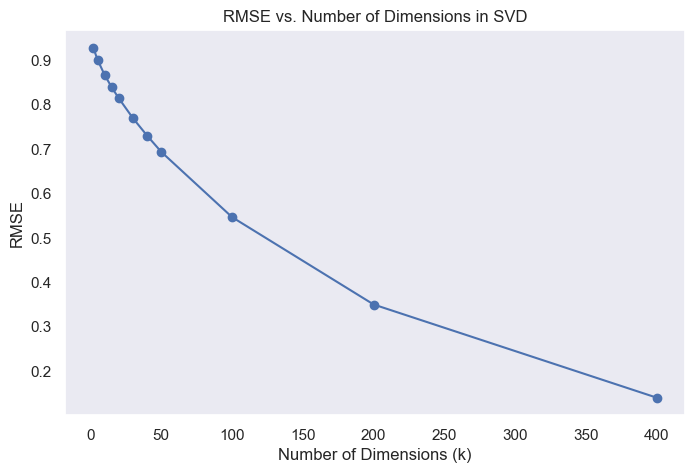

In [11]:
# Afficher la courbe RMSE en fonction du nombre de dimensions.
plt.figure(figsize=(8,5))
plt.plot(list_k, list_RMSE_svc, marker='o', linestyle='-')
plt.xlabel("Number of Dimensions (k)")
plt.ylabel("RMSE")
plt.title("RMSE vs. Number of Dimensions in SVD")
plt.grid()
plt.show()

In [12]:
# Déterminer la meilleure valeur de K
k_optimal = list_k[np.argmin(list_RMSE_svc)]
print(f"La meilleure valeur de k selon le RMSE est : {k_optimal}")

La meilleure valeur de k selon le RMSE est : 400


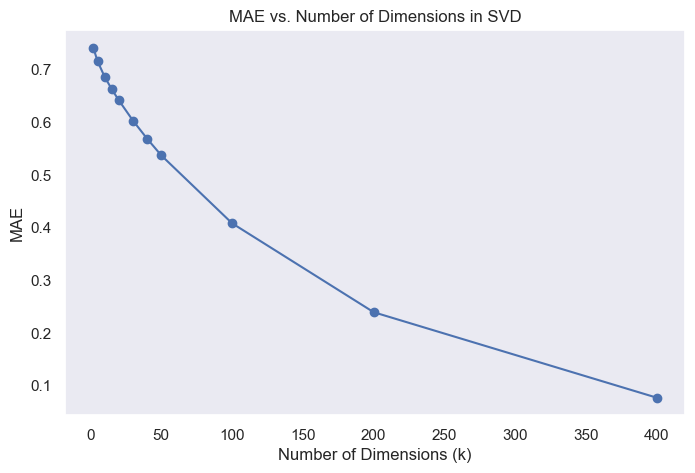

In [13]:
# Afficher la courbe MAE en fonction du nombre de dimensions.
plt.figure(figsize=(8,5))
plt.plot(list_k, list_MAE_svc, marker='o', linestyle='-')
plt.xlabel("Number of Dimensions (k)")
plt.ylabel("MAE")
plt.title("MAE vs. Number of Dimensions in SVD")
plt.grid()
plt.show()

In [14]:
# Déterminer la meilleure valeur de K
k_optimal = list_k[np.argmin(list_MAE_svc)]
print(f"La meilleure valeur de k selon le MAE est : {k_optimal}")

La meilleure valeur de k selon le MAE est : 400


**Validation croisée**

Indication: 
- On itère sur les replis avant d'itérer sur le nombre de valeurs singulières $k$ que l'on retient. C'est un détail qui permet d'être plus performant en temps de calcul.
- Un variable contenant les indices a déjà été crée plus haut

In [15]:
%%time
list_RMSE = []
list_MAE  = []

for i in range(nbre_replis):
    list_RMSE_i = []
    list_MAE_i  = []

    MUI_numpy_train_idx = np.concatenate(idx_split[:i] + idx_split[i+1:])
    MUI_numpy_test_idx = idx_split[i]
    
    ## On enlève les valeurs de test de la matrice d'entrainement, et les valeurs de train dans la matrice de test
    R_train = np.copy(MUI_numpy)
    MUI_numpy_valid = np.copy(MUI_numpy)
    
    row_train, col_train = zip(*[(idx//MUI_numpy.shape[1], idx%MUI_numpy.shape[1]) for idx in MUI_numpy_train_idx])
    row_test, col_test = zip(*[(idx//MUI_numpy.shape[1], idx%MUI_numpy.shape[1]) for idx in MUI_numpy_test_idx])

    #print(len(row_train), len(col_train))

    ## On redonne la structure de matrice aux ensembles de test et d'entrainement
    R_train[row_test, col_test] = np.nan
    MUI_numpy_valid[row_train, col_train] = np.nan

    print(R_train.shape)
    # Centré
    R_biais    = Biais_mat(R_train)

    R_centered = R_train - R_biais
    R_centered[np.isnan(R_centered)] = 0

    # Decomposition
    u, sigma, v_trans = SVD_decomp(R_centered)
    for k in list_k:
        # Pred
        R_pred = SVD_matpred(u, sigma, v_trans, k)

        # row_idx, col_idx = np.where(np.isnan(R_pred))
        # print("Rows:", row_idx.shape)
        # print("Cols:", col_idx)
        list_RMSE_i.append(RMSE_mat(R_pred + R_biais, MUI_numpy_valid))
        list_MAE_i.append(MAE_mat(R_pred + R_biais, MUI_numpy_valid))

    list_RMSE.append(np.array(list_RMSE_i))
    list_MAE.append(np.array(list_MAE_i))

list_RMSE = np.array(list_RMSE)
list_MAE  = np.array(list_MAE)

(943, 1682)


C:\Users\gabco\AppData\Local\Temp\ipykernel_10772\422087992.py:10: RuntimeWarning: Mean of empty slice
  item_mean = np.nanmean(R, axis=0)


(943, 1682)
(943, 1682)
(943, 1682)
(943, 1682)
CPU times: total: 4.34 s
Wall time: 4.8 s


In [16]:
# Mean per value of k
list_RMSE_mean = list_RMSE.mean(axis=0)
list_MAE_mean = list_MAE.mean(axis=0)

In [17]:
values_of_k    = [k for i in range(nbre_replis) for k in list_k]
values_of_rmse = list_RMSE.flatten()
df_q1 = pd.DataFrame.from_dict({"Number of Dimensions Taken": values_of_k, "Root Mean Square Error on Validation": values_of_rmse})
df_q1.sort_values("Number of Dimensions Taken").head()

,Number of Dimensions Taken,Root Mean Square Error on Validation
0,2,0.952172
11,2,0.958928
22,2,0.955277
33,2,0.968456
44,2,0.959368


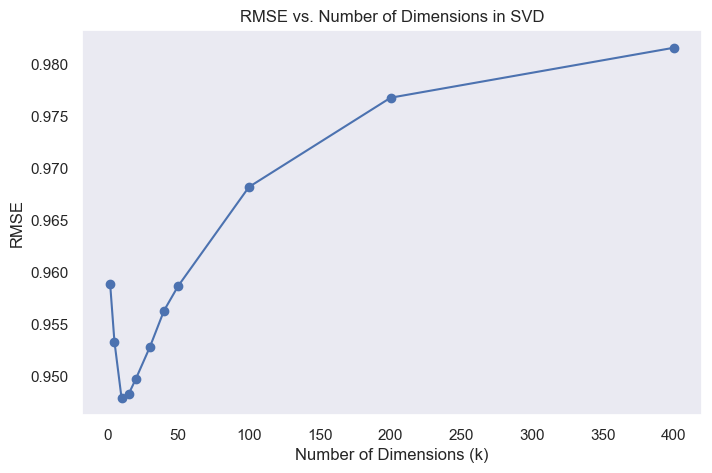

In [18]:
# Afficher les courbes de RMSE en fonction du nombre de dimensions choisies
plt.figure(figsize=(8,5))
plt.plot(list_k, list_RMSE_mean, marker='o', linestyle='-')
plt.xlabel("Number of Dimensions (k)")
plt.ylabel("RMSE")
plt.title("RMSE vs. Number of Dimensions in SVD")
plt.grid()
plt.show()

In [19]:
# Déterminer la meilleure valeur de K et comparé vos resultats avec ceux obtenus dans l'approches sans validation croisée.
k_optimal = list_k[np.argmin(list_RMSE_mean)]
print(f"La meilleure valeur de k selon le RMSE est : {k_optimal}")

La meilleure valeur de k selon le RMSE est : 10


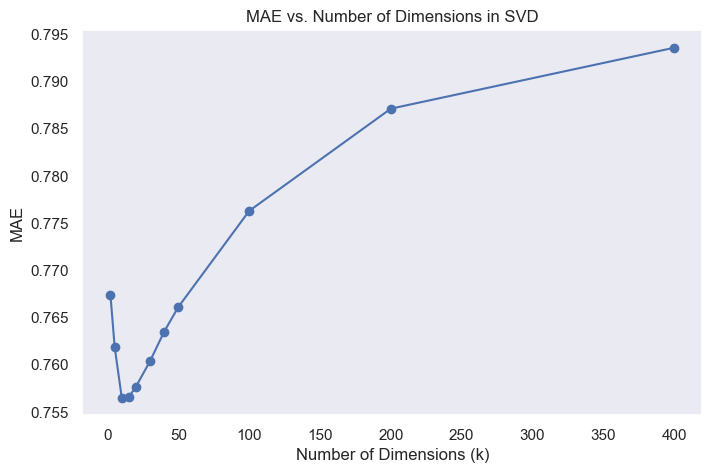

In [20]:
# Afficher la courbe MAE en fonction du nombre de dimensions.
plt.figure(figsize=(8,5))
plt.plot(list_k, list_MAE_mean, marker='o', linestyle='-')
plt.xlabel("Number of Dimensions (k)")
plt.ylabel("MAE")
plt.title("MAE vs. Number of Dimensions in SVD")
plt.grid()
plt.show()

In [21]:
# Déterminer la meilleure valeur de K et comparé vos resultats avec ceux obtenus dans l'approches sans validation croisée.
k_optimal = list_k[np.argmin(list_MAE_mean)]
print(f"La meilleure valeur de k selon le MAE est : {k_optimal}")

La meilleure valeur de k selon le MAE est : 10


**Prédiction**

Supposons un nouvel utilisateur qui a visionné le film "Clockwork Orange" (numéro 179, indice 178 si les indices commencent à 0).  Utilisez l'approche SVD de prédiction pour lui recommander 10 films.

In [22]:
# Fonction qui prend en argument un vecteur ou une matrice de votes d'un utilisateur (lignes de la matrice) et retourne les indices des k films les plus similaires
def k_most_similar(votes, movie_id, k=10):
    # à compléter
    R_biais    = Biais_mat(votes)
    R_centered = votes - R_biais
    R_centered[np.isnan(R_centered)] = 0

    u, sigma, vt = SVD_decomp(R_centered)
    
    R_pred = SVD_matpred(u, sigma, v_trans, 10) + R_biais

    movie_ratings = R_pred[:, movie_id]
    
    def cosine_similarity(a, b):
        dot_product = np.dot(a, b)
        norm_a = np.linalg.norm(a)
        norm_b = np.linalg.norm(b)
        return dot_product / (norm_a * norm_b)
    
    similarities = cosine_similarity([movie_ratings], R_pred)
    
    # Get the top k recommended movies by sorting the predicted ratings in descending order
    similar_movie_indices = similarities.argsort()[0][-k-1:-1]
    
    return similar_movie_indices


# Movie ID for "Clockwork Orange" (index 178, assuming 0-indexed)
movie_id = 178

# Get the 10 most similar movies to "Clockwork Orange"
recommended_movies = k_most_similar(MUI_numpy, movie_id, k=10)

print("Recommended Movies:", recommended_movies)

# votes_for_user = votes.loc[votes['item.id'] == 179]
# print(votes_for_user)

# unique_user_ids = votes_for_user['user.id'].unique()
# random_user_id = np.random.choice(unique_user_ids)
# user_ratings = MUI_numpy[random_user_id - 1]
# print(f"Random User ID: {random_user_id}")
# print(user_ratings)



Recommended Movies: [1448  813 1466 1598 1188 1200 1121 1652 1292 1535]


## Question 2 (8 points)

L’algorithme K-means est une méthode de regroupement/agglomération (*clustering*) qui divise les utilisateurs (ou items) en plusieurs classes homogènes basées sur leurs similarités. Dans le cadre de ce TP, K-means sert à :

- Identifier des groupes d’utilisateurs ou d’items similaires selon leurs interactions (par exemple, des utilisateurs ayant des préférences proches ou des films avec des profils similaires de spectateurs).
- Simplifier les prédictions en supposant que les membres d’un même groupe auront des comportements similaires (par exemple, des utilisateurs d’un même cluster auront des votes comparables).
- Tester comment le choix du nombre de classes ($k$) influence la précision des prédictions (RMSE) et la capacité du modèle à capturer les relations dans les données.

Cette approche permet d’explorer comment le regroupement peut simplifier la personnalisation des recommandations et servir d’alternative (ou de complément) à d'autres méthodes comme SVD ou les filtres collaboratifs.

**Instructions :**
  
Utilisez une approche par agglomération (clustering) pour prédire les votes et calculez l'erreur quadratique moyenne. Utilisez 2, 5, 10, 20, et 40 classes. Prenez l'approche K-moyenne (K-means) et utilisez la corrélation comme mesure de distance et une validation croisée de 5 replis pour établir quel est le nombre de classes à retenir parmi les 5 mentionnés. Une bonne explication de l'algorithme k-means est fournie par Alexandre Ihler dans cette [vidéo](https://www.youtube.com/watch?v=mfqmoUN-Cuw&feature=youtu.be).

### Distances
Afin d'effectuer la mesure de distance dans l'approches KMEANS, les fonctions suivantes calculent la distance de Pearson et la distance Euclidienne.

#### Distance de Pearson

In [23]:
## Distance de Pearson avec des Nans

def PearsonDist(x, y):
    if(len(x.shape) < len(y.shape)):# For Cluster Assignment
        x = np.expand_dims(x, axis=0).repeat(y.shape[0], axis=0)
        nan_or = np.logical_or(np.isnan(x), np.isnan(y))
        corr   = [pearsonr(x[i, ~nan_or[i]], y[i, ~nan_or[i]])[0] if((~nan_or[i]).sum() >=2) else 1 for i in range(y.shape[0])]
    elif(len(x.shape) > len(y.shape)):
        y = np.expand_dims(y, axis=0).repeat(x.shape[0], axis=0)
        nan_or = np.logical_or(np.isnan(x), np.isnan(y))
        corr   = [pearsonr(x[i, ~nan_or[i]], y[i, ~nan_or[i]])[0] if((~nan_or[i]).sum() >=2) else 1 for i in range(y.shape[0])]
    else:# For training phase
        nan_or = np.logical_or(np.isnan(x), np.isnan(y))
        if((~nan_or).sum() <2):
            return 1
        corr   = pearsonr(x[~nan_or], y[~nan_or])[0]
    return 1 - np.abs(corr)

#### Meilleure version de distance de pearson
Cette simplification de la distance de pearson est plus rapide que l'implémentation plus haut. Aussi, elle est nécessaire, car après quelques tests dans la cellule plus bas nous avons remarqué que l'assignation de clusters avec la fonction PearsonDist pouvait donner un loop infini qui prenait beaucoup de temps à se faire résoudre. Nous avons donc changé l'implémentation, car après 1h de runtime pour la fonction de base l'algorithme n'avait même pas fini de run son premier fold...

In [44]:
import numpy as np

def SimplePearsonDist(x, y):
    # Mask out NaN values
    nan_or = np.isnan(x) | np.isnan(y)
    
    # Keep only the valid values (non-NaN)
    x_valid = x[~nan_or]
    y_valid = y[~nan_or]
    
    # If there are fewer than 2 valid data points, return 1 (no correlation)
    if len(x_valid) < 2:
        return 1
    
    # Compute the Pearson correlation
    mean_x = np.mean(x_valid)
    mean_y = np.mean(y_valid)
    
    # Pearson formula (without covariance normalization)
    corr = np.dot(x_valid - mean_x, y_valid - mean_y) / (np.linalg.norm(x_valid - mean_x) * np.linalg.norm(y_valid - mean_y))
    
    return 1 - corr  # Return distance, not correlation


#### Distance Euclidienne

In [ ]:
def EuclidDist(x, y):
    # x, y = np.array(x), np.array(y)
    nan_or = np.logical_or(np.isnan(x), np.isnan(y))
    if((~nan_or).sum() <2):
        return nan_or.shape[0]
    return np.linalg.norm(x[~nan_or] - y[~nan_or])

In [25]:
##Pour la Validation croisée
## Création des indices pour les valeurs différentes de np.nan
indices    = np.arange(0, MUI_numpy.shape[0]*MUI_numpy.shape[1])
indices_na = indices[~np.isnan(MUI_numpy_flat)]

## Split Train Test des indices
nbre_replis = 5
np.random.shuffle(indices_na)
idx_split = np.split(indices_na, nbre_replis)

#### Tests de temps pris par PearsonDist

Il est difficile de montrer la différence de temps entre PearsonDist et SimplePearsonDist, puisque souvent PearsonDist reste pris dans un loop inifini, ce qui l'empêche de compléter la fonction dans un temps raisonnable.

In [54]:
from nltk.cluster import KMeansClusterer
import time

print(f"taille de nos points: {MUI_numpy.shape[0], MUI_numpy.shape[1]}")
for cluster_size in [1, 2, 4]:
    for data_size in [10, 20, 50, 100, 1000]:
        x = np.random.rand(data_size, 4)
        start_pearson = time.time()
        kclusterer = KMeansClusterer(cluster_size, distance=SimplePearsonDist, repeats=10)
        assigned_clusters = kclusterer.cluster(x, assign_clusters=True)
        time_taken_pearson = time.time() - start_pearson
        
        start_eucledian = time.time()
        kclusterer = KMeansClusterer(cluster_size, distance=EuclidDist)
        assigned_clusters = kclusterer.cluster(x, assign_clusters=True)
        time_taken_eucledian = time.time() - start_eucledian

        print(cluster_size, data_size, time_taken_pearson, time_taken_eucledian)


taille de nos points: (943, 1682)
1 10 0.009435892105102539 0.0
1 20 0.013224363327026367 0.0009999275207519531
1 50 0.02089381217956543 0.0
1 100 0.0542750358581543 0.0
1 1000 0.42236757278442383 0.020472288131713867
2 10 0.019069910049438477 0.0
2 20 0.025888681411743164 0.0006651878356933594
2 50 0.08025193214416504 0.002004861831665039
2 100 0.2626020908355713 0.013899087905883789
2 1000 5.574341058731079 0.1714484691619873
4 10 0.02794957160949707 0.0
4 20 0.06784415245056152 0.0025513172149658203
4 50 0.23405742645263672 0.006940603256225586
4 100 0.5428335666656494 0.029604196548461914
4 1000 19.996031999588013 1.1371848583221436


In [56]:
%%time

list_RMSE_q2_pearson = []
list_MAE_q2_pearson  = []
list_RMSE_q2_euclid = []
list_MAE_q2_euclid  = []
list_k_q2    = [2, 5, 10, 20, 40]
#list_k_q2    = [2]

for i in range(nbre_replis):
    list_RMSE_i_pearson = []
    list_MAE_i_pearson  = []
    list_RMSE_i_euclid = []
    list_MAE_i_euclid  = []

    idx_valid = idx_split[i]
    idx_train = np.concatenate([idx_split[j] for j in range(nbre_replis) if j != i]) 

    # row_idx = np.where(np.isnan(MUI_numpy_flat))
    # print("Rows:",len(MUI_numpy_flat) - len(row_idx[0]))

    # On enlève les valeurs de test de la matrice d'entrainement, et vice versa
    MUI_numpy_flat_train = MUI_numpy_flat.copy()
    MUI_numpy_flat_valid = np.full_like(MUI_numpy_flat, np.nan)
    #print(MUI_numpy_flat_valid.shape)

    MUI_numpy_flat_valid[idx_valid] = MUI_numpy_flat[idx_valid]  # Fill valid set
    MUI_numpy_flat_train[idx_valid] = np.nan  # Remove validation values from training

    row_idx = np.where(np.isnan(MUI_numpy_flat_valid))

    # On redonne la structure de matrice aux ensembles de test et d'entrainement
    MUI_numpy_train = MUI_numpy_flat_train.reshape(MUI_numpy.shape)
    MUI_numpy_valid = MUI_numpy_flat_valid.reshape(MUI_numpy.shape)


    for num_cluster in list_k_q2:
        print(num_cluster)
        ## Remplacer les Nans par le vote moyen pour que K-Means converge en utilisant la fonction Biais_mat définie plus haut.
        data                 = MUI_numpy_train.copy()
        mask = np.isnan(data)
        data[np.isnan(data)] = Biais_mat(data)[mask]

        #print(data.dtype)
        print("training...")
        ## Entrainement du K-Means
        kclusterer_pearson        = KMeansClusterer(num_cluster, SimplePearsonDist, repeats=5)
        kclusterer_euclid        = KMeansClusterer(num_cluster, EuclidDist, repeats=5)
        print("kmeanscluterer created")
        assigned_clusters_pearson = np.array(kclusterer_pearson.cluster(data, assign_clusters=True))
        assigned_clusters_euclid = np.array(kclusterer_euclid.cluster(data, assign_clusters=True))
        print("training done")

        ## Extraction des centroides
        centroids_pearson         = np.array([np.nanmean(data[assigned_clusters_pearson==k], axis=0) for k in range(num_cluster)])
        centroids_euclid         = np.array([np.nanmean(data[assigned_clusters_euclid==k], axis=0) for k in range(num_cluster)])

        ## Matrice de prédictions
        assigned_clusters_valid_pearson = np.array([kclusterer_pearson.classify(v) for v in MUI_numpy_valid])
        assigned_clusters_valid_euclid = np.array([kclusterer_euclid.classify(v) for v in MUI_numpy_valid])
        R_pred_pearson                  = centroids[assigned_clusters_valid_pearson]
        R_pred_euclid                  = centroids[assigned_clusters_valid_euclid]

        list_RMSE_i_pearson.append(RMSE_mat(R_pred_pearson, MUI_numpy_valid))
        list_MAE_i_pearson.append(MAE_mat(R_pred_pearson, MUI_numpy_valid))
        list_RMSE_i_euclid.append(RMSE_mat(R_pred_euclid, MUI_numpy_valid))
        list_MAE_i_euclid.append(MAE_mat(R_pred_euclid, MUI_numpy_valid))

    list_RMSE_q2_pearson.append(np.array(list_RMSE_i_pearson))
    list_MAE_q2_pearson.append(np.array(list_MAE_i_pearson))
    list_RMSE_q2_euclid.append(np.array(list_RMSE_i_euclid))
    list_MAE_q2_euclid.append(np.array(list_MAE_i_euclid))

list_RMSE_q2_pearson = np.array(list_RMSE_q2_pearson)
list_MAE_q2_pearson  = np.array(list_MAE_q2_pearson)
list_RMSE_q2_euclid = np.array(list_RMSE_q2_euclid)
list_MAE_q2_euclid  = np.array(list_MAE_q2_euclid)

2
training...
kmeanscluterer created


C:\Users\gabco\AppData\Local\Temp\ipykernel_10772\422087992.py:10: RuntimeWarning: Mean of empty slice
  item_mean = np.nanmean(R, axis=0)


training done
5
training...
kmeanscluterer created


C:\Users\gabco\AppData\Local\Temp\ipykernel_10772\849769942.py:20: RuntimeWarning: invalid value encountered in scalar divide
  corr = np.dot(x_valid - mean_x, y_valid - mean_y) / (np.linalg.norm(x_valid - mean_x) * np.linalg.norm(y_valid - mean_y))


training done
10
training...
kmeanscluterer created
training done
20
training...
kmeanscluterer created
training done
40
training...
kmeanscluterer created
training done
2
training...
kmeanscluterer created
training done
5
training...
kmeanscluterer created
training done
10
training...
kmeanscluterer created
training done
20
training...
kmeanscluterer created
training done
40
training...
kmeanscluterer created
training done
2
training...
kmeanscluterer created
training done
5
training...
kmeanscluterer created
training done
10
training...
kmeanscluterer created
training done
20
training...
kmeanscluterer created
training done
40
training...
kmeanscluterer created
training done
2
training...
kmeanscluterer created
training done
5
training...
kmeanscluterer created
training done
10
training...
kmeanscluterer created
training done
20
training...
kmeanscluterer created
training done
40
training...
kmeanscluterer created
training done
2
training...
kmeanscluterer created
training done
5
tra

In [57]:
list_RMSE_mean_q2_pearson = list_RMSE_q2_pearson.mean(axis=0)
list_MAE_mean_q2_pearson = list_MAE_q2_pearson.mean(axis=0)
list_RMSE_mean_q2_euclid = list_RMSE_q2_euclid.mean(axis=0)
list_MAE_mean_q2_euclid = list_MAE_q2_euclid.mean(axis=0)

In [58]:
values_of_k_q2    = [k for i in range(nbre_replis) for k in list_k_q2]
values_of_rmse_q2 = list_RMSE_q2_pearson.flatten()
df_q2 = pd.DataFrame.from_dict({"Number of Dimensions Taken": values_of_k_q2, "Root Mean Square Error on Validation": values_of_rmse_q2})
df_q2.sort_values("Number of Dimensions Taken").head()

,Number of Dimensions Taken,Root Mean Square Error on Validation
0,2,1.277935
5,2,1.265359
15,2,1.280644
10,2,1.285207
20,2,1.298857


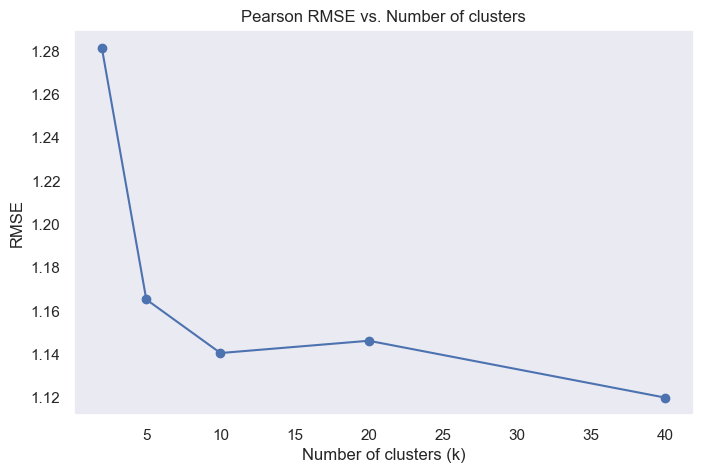

In [59]:
# Afficher la courbe RMSE en fonction du nombre de dimensions.
plt.figure(figsize=(8,5))
plt.plot(list_k_q2, list_RMSE_mean_q2_pearson, marker='o', linestyle='-')
plt.xlabel("Number of clusters (k)")
plt.ylabel("RMSE")
plt.title("Pearson RMSE vs. Number of clusters")
plt.grid()
plt.show()

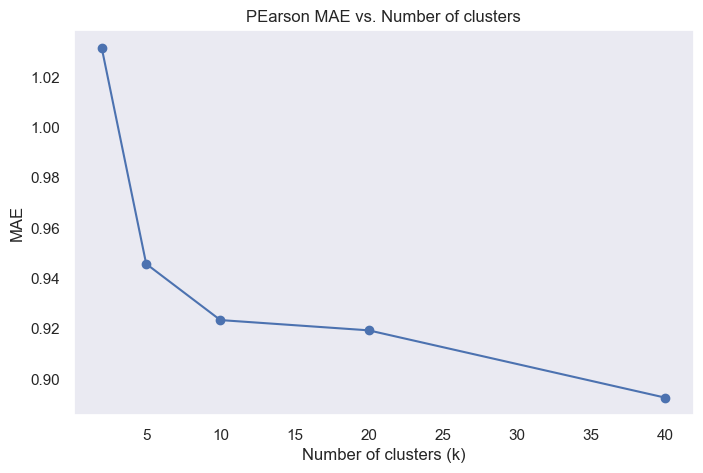

In [60]:
# Afficher la courbe RMSE en fonction du nombre de dimensions.
plt.figure(figsize=(8,5))
plt.plot(list_k_q2, list_MAE_mean_q2_pearson, marker='o', linestyle='-')
plt.xlabel("Number of clusters (k)")
plt.ylabel("MAE")
plt.title("PEarson MAE vs. Number of clusters")
plt.grid()
plt.show()

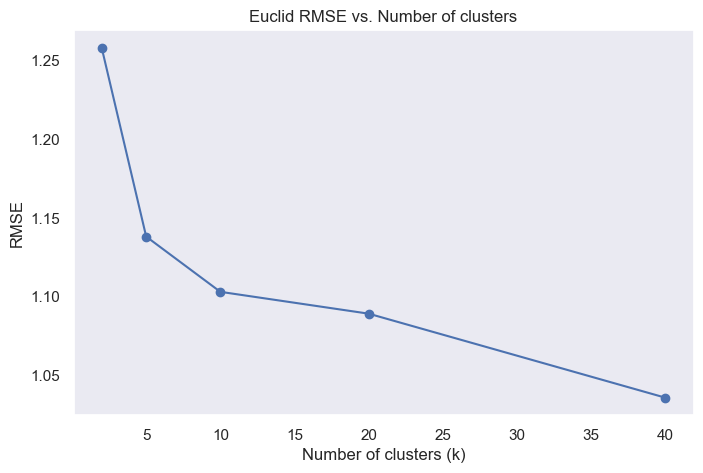

In [61]:
# Afficher la courbe RMSE en fonction du nombre de dimensions.
plt.figure(figsize=(8,5))
plt.plot(list_k_q2, list_RMSE_mean_q2_euclid, marker='o', linestyle='-')
plt.xlabel("Number of clusters (k)")
plt.ylabel("RMSE")
plt.title("Euclid RMSE vs. Number of clusters")
plt.grid()
plt.show()

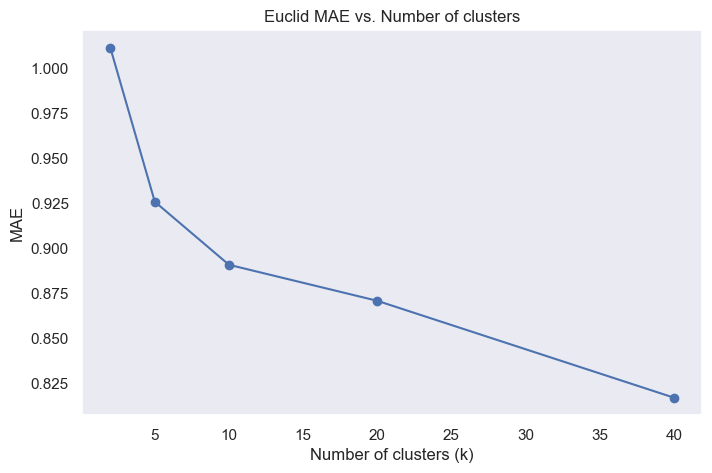

In [62]:
# Afficher la courbe RMSE en fonction du nombre de dimensions.
plt.figure(figsize=(8,5))
plt.plot(list_k_q2, list_MAE_mean_q2_euclid, marker='o', linestyle='-')
plt.xlabel("Number of clusters (k)")
plt.ylabel("MAE")
plt.title("Euclid MAE vs. Number of clusters")
plt.grid()
plt.show()

In [ ]:
# Conclure